In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import os, sys
torch.autograd.set_detect_anomaly(True)

sys.path.append('../')

from model.generators.enlighten_gan_generator import GeneratorEnlightenGAN
from model.discriminators.enlighten_gan_global_discriminator import GlobalDiscriminatorEnlightenGAN
from model.discriminators.enlighten_gan_local_discriminator import LocalDiscriminatorEnlightenGAN
from model.model import Model
from model.attention_map import AttentionMapGray
from model.loses.gan_loss import GanLoss
from model.vgg import Vgg16
from model.loses.vgg_loss import VGGLoss
from utils import patches
from utils import image_utils
# from utils import weights
from data_loader import ABDataset

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import time
import datetime

from utils import image_utils, image_tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda")
netG = GeneratorEnlightenGAN()
netG.to(device)

netD_global = GlobalDiscriminatorEnlightenGAN()
netD_global.to(device)

num_patches = 6
netD_local = LocalDiscriminatorEnlightenGAN()
netD_local.to(device)

attention_map = AttentionMapGray()
criterion = GanLoss()
vgg_loss = VGGLoss()

netVgg = Vgg16()
netVgg.to(device)
model_dir = '../saved_models'
netVgg.load_state_dict(torch.load(os.path.join(model_dir, 'vgg16.weight')))
netVgg.eval()
netVgg.requires_grad_(False)

model = Model(netG, netD_global, netD_local, criterion, netVgg, vgg_loss)

niter = 100
niter_decay = 100
dataset_root = '/home/student/Documents/alena/thesis/enlighte-gan-dataset'

dataset = ABDataset(dataset_root, attention_map,subroot_dark='dark_large', subroot_normal='normal_large')
dataset = DataLoader(dataset, batch_size=7, num_workers=1)



In [ ]:
writer = SummaryWriter()
for epoch in tqdm(range(niter + niter_decay + 1)):
    for i, data in enumerate(dataset):
        img_dark = data['dark'].to("cuda")
        img_normal = data['normal'].to("cuda")
        img_gray = data['gray'].to("cuda")
        img_dark = data['input'].to("cuda")

        img_generated = model.forward(img_dark, img_gray)
        with torch.no_grad():
            patches_dark_img, patches_normal_img, patches_generated_img = patches.create_patch(img_dark,
                                                                                               img_normal,
                                                                                               img_generated,
                                                                                               num_patches=num_patches)

        model.optimizer_G.zero_grad()
        lossG, loss_D_global, loss_D_local, loss_vgg = model.loss_G(img_dark, img_normal, img_generated, patches_dark_img,
                              patches_generated_img)
        lossG.backward()
        model.optimizer_G.step()

        model.optimizerD_global.zero_grad()
        lossD_global = model.loss_D_global(img_normal, img_generated.detach())
        lossD_global.backward()

        model.optimizerD_local.zero_grad()
        lossD_local = model.loss_D_local(patches_normal_img, patches_generated_img)
        lossD_local.backward()

        model.optimizerD_global.step()
        model.optimizerD_local.step()
        
    #     plt.subplots()
    #     img_grid = torchvision.utils.make_grid(patches_normal_img[0])
    #     plt.imshow(img_grid.detach().permute(1, 2, 0).cpu().numpy())
    #     image_utils.matplotlib_imshow(img_grid.detach().cpu())
    #     # plt.imshow(((img_grid.permute(1, 2, 0) + 1 ) * 0.5*255).detach().cpu().numpy().astype(np.uint8))
    #     writer.add_image('mean %f, max %f, min %f' %(patches_normal_img[0][0, :, :, :].mean(), patches_normal_img[0][0, :, :, :].max(), patches_normal_img[0][0, :, :, :].min()), img_grid)
    #     break
    # break
    writer.add_scalar('loss G', lossG.item(), epoch)
    writer.add_scalar('loss G, global', loss_D_global.item(), epoch)
    writer.add_scalar('loss G, local', loss_D_local.item(), epoch)
    writer.add_scalar('loss G, VGG', loss_vgg.item(), epoch)
    
    writer.add_scalar('loss D global', lossD_global.item(), epoch)
    writer.add_scalar('loss D local', lossD_local.item(), epoch)
        

    if epoch > niter:
        model.update_learning_rate(niter)
writer.close()

  0%|          | 0/201 [00:00<?, ?it/s]/home/student/miniconda3/envs/my-engan/lib/python3.8/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
 27%|██▋       | 54/201 [1:50:18<5:00:01, 122.46s/it]

In [ ]:
time_checkpoint = str(datetime.datetime.now())
os.mkdir('../saved_models/checkpoints/%s' % time_checkpoint)

torch.save(model.state_dict(), '../saved_models/checkpoints/%s/model' % time_checkpoint)

In [6]:
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

(592, 400)


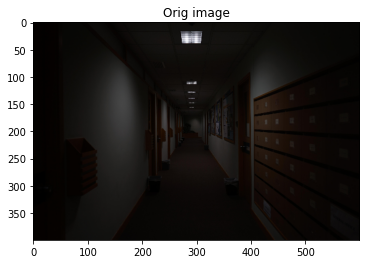

In [8]:
img_dark_orig = image_utils.load_image('/home/student/Documents/alena/thesis/enlighte-gan-dataset/test/dark/13_10.png')
plt.title('Orig image')
plt.imshow(img_dark_orig)

if img_dark_orig.size[0] > 1000 or img_dark_orig.size[1] > 1000:
    h, w = img_dark_orig.size
    img_dark_orig = img_dark_orig.resize((h//2, w//2))

img_data_cropped = image_utils.crop_image(img_dark_orig, power=16)
print(img_data_cropped.size)
    
# h, w = img_dark_orig.size
# pix_to_crop_h = h % 16
# pix_to_crop_w = w % 16
# img_data_cropped = img_dark_orig.crop((0, 0, h - pix_to_crop_h, w - pix_to_crop_w))

img_dark = image_tf.get_transforms(False, 320)(img_data_cropped)

gray = attention_map(img_dark)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


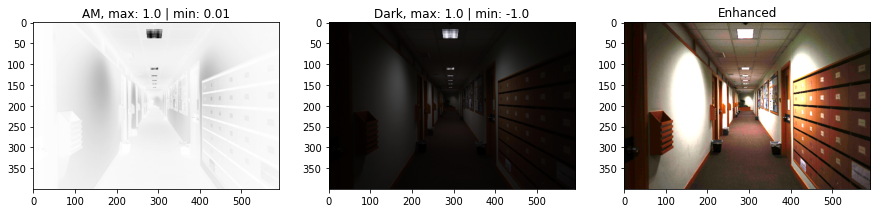

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 10))

ax[0].set_title('AM, max: ' + str(round(gray.max().item(), 2)) + " | min: " + str(round(gray.min().item(), 2)))
ax[0].imshow(gray.permute(1, 2, 0),cmap='gray')

ax[1].set_title('Dark, max: ' + str(round(img_dark.max().item(), 2)) + " | min: " + str(round(img_dark.min().item(), 2)))
ax[1].imshow((img_dark.permute(1, 2, 0) + 1) /2, cmap='gray')

ax[2].set_title('Enhanced')
ax[2].imshow((2 + img_dark.permute(1, 2, 0)) ** 3.0 - 1) 

In [10]:
# print(os.path.join(model_dir, '/checkpoints/%s/netG'%time_checkpoint))

In [4]:
time_checkpoint = '2022-01-27 13:37:10.273665'

In [5]:
device = torch.device("cuda")

netG = GeneratorEnlightenGAN()
netG.to(device)
netG = torch.nn.DataParallel(netG, device_ids=[0])

netD_global = GlobalDiscriminatorEnlightenGAN()
netD_global.to(device)
netD_global = torch.nn.DataParallel(netD_global, device_ids=[0])

netD_local = LocalDiscriminatorEnlightenGAN(n=5)
netD_local.to(device)
netD_local = torch.nn.DataParallel(netD_local, device_ids=[0])

attention_map = AttentionMapGray()
criterion = GanLoss()
vgg_loss = VGGLoss()

netVgg = Vgg16()
netVgg.to(device)
model_dir = '../saved_models'
netVgg.load_state_dict(torch.load(os.path.join(model_dir, 'vgg16.weight')))
netVgg.eval()
netVgg = torch.nn.DataParallel(netVgg, device_ids=[0])

model_test = Model(netG, netD_global, netD_local, criterion, netVgg, vgg_loss)

model_test.load_state_dict(torch.load('../saved_models/checkpoints/%s/model'%time_checkpoint))

<All keys matched successfully>

In [6]:
prediction = model_test._netG.forward(img_dark[None, :, :, :].cuda(), gray[None, :, :, :].cuda())

NameError: name 'img_dark' is not defined

max:  254.99343872070312 | min:  0.02371072769165039


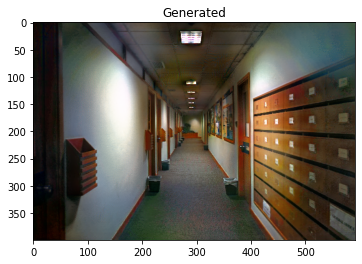

In [11]:
predicted_image = (prediction.detach().cpu()[0, :, :, :].permute(1, 2, 0) + 1 ) * 255 /2
print('max: ', predicted_image.max().item(), "| min: ", predicted_image.min().item())
plt.title('Generated')
plt.imshow(predicted_image.numpy().astype(int))

In [7]:
img_dir = '/home/student/Documents/alena/thesis/enlighte-gan-dataset/test/dark/'
img_files = os.listdir(img_dir)

imgs_dark = []
grays = []

for img_file in img_files:
    path = os.path.join(img_dir, img_file)
    img_dark_orig = image_utils.load_image(path)
# plt.title('Orig image')
# plt.imshow(img_dark_orig)

    if img_dark_orig.size[0] > 1000 or img_dark_orig.size[1] > 1000:
        h, w = img_dark_orig.size
        img_dark_orig = img_dark_orig.resize((h//2, w//2))

    img_data_cropped = image_utils.crop_image(img_dark_orig, power=16)

    imgs_dark.append(image_tf.get_transforms(False, 320)(img_data_cropped))

    grays.append(attention_map(imgs_dark[-1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


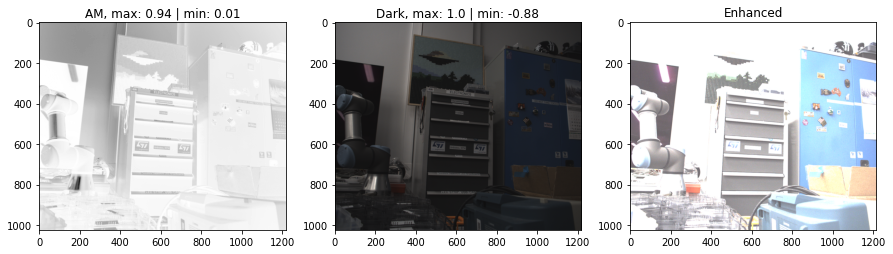

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 10))

ax[0].set_title('AM, max: ' + str(round(grays[0].max().item(), 2)) + " | min: " + str(round(grays[0].min().item(), 2)))
ax[0].imshow(grays[0].permute(1, 2, 0),cmap='gray')

ax[1].set_title('Dark, max: ' + str(round(imgs_dark[0].max().item(), 2)) + " | min: " + str(round(imgs_dark[0].min().item(), 2)))
ax[1].imshow((imgs_dark[0].permute(1, 2, 0) + 1) /2, cmap='gray')

ax[2].set_title('Enhanced')
ax[2].imshow((2 + imgs_dark[0].permute(1, 2, 0)) ** 3.0 - 1) 

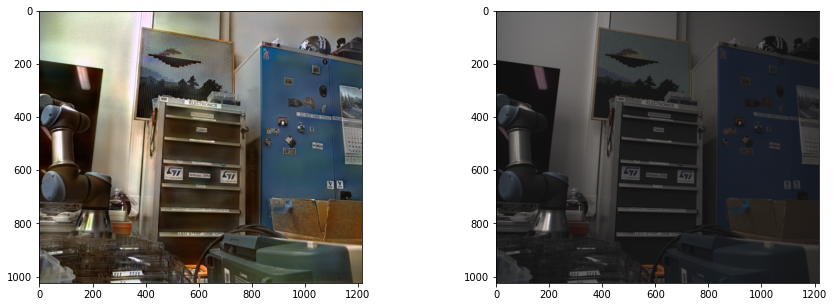

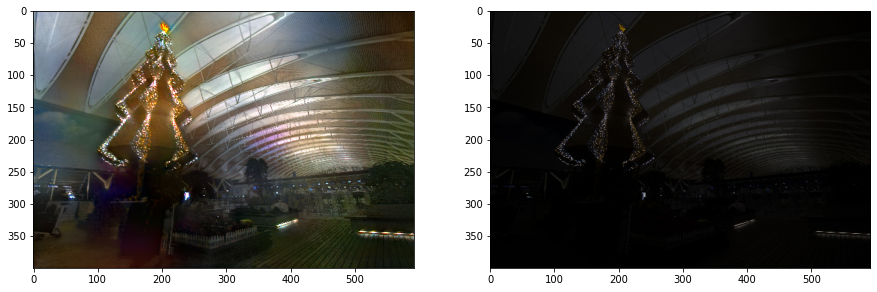

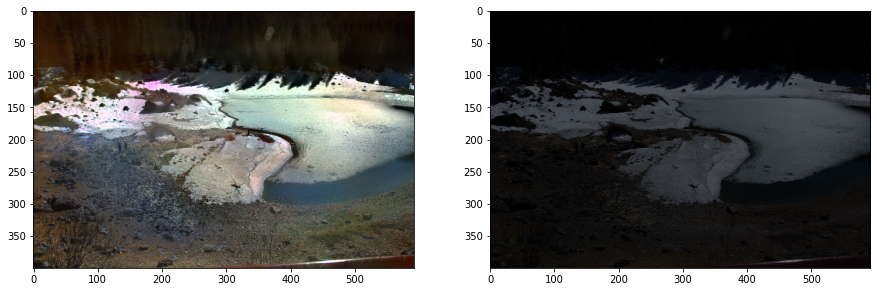

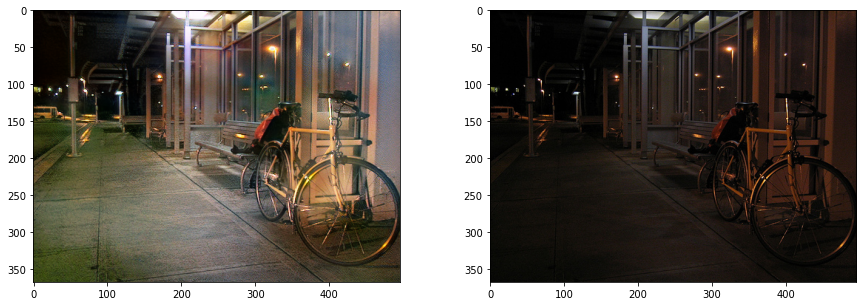

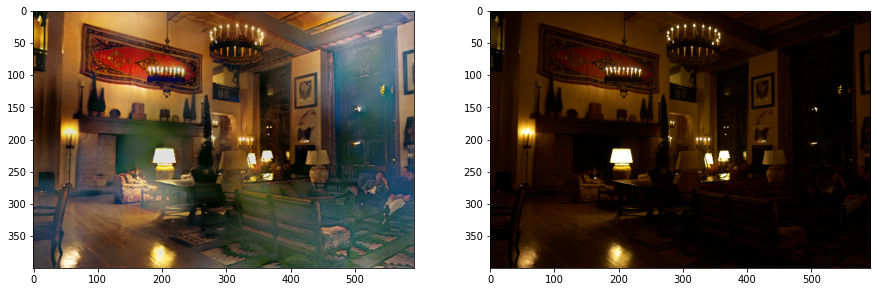

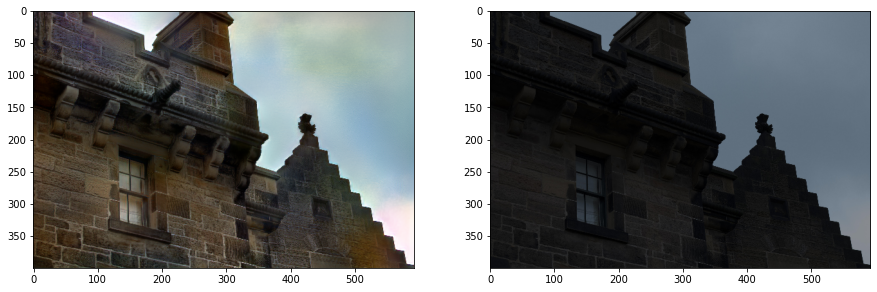

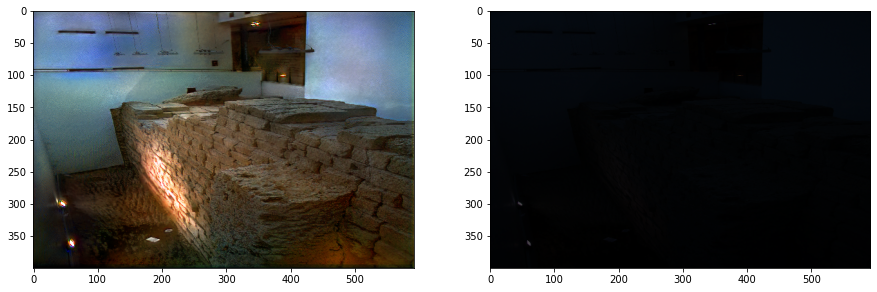

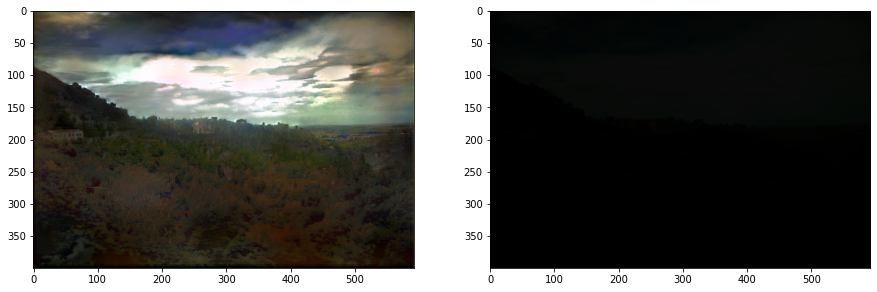

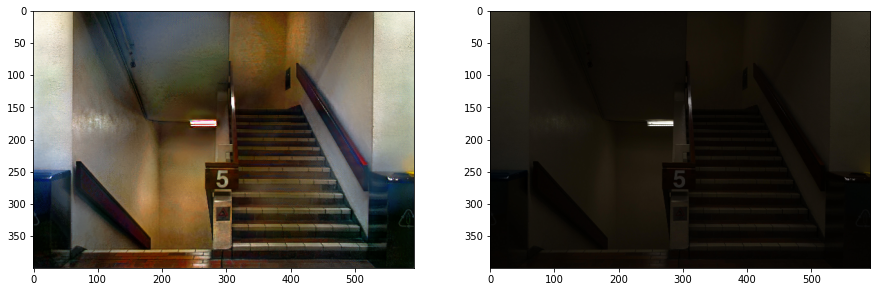

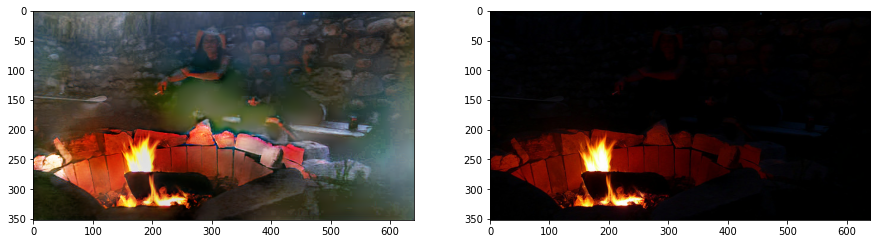

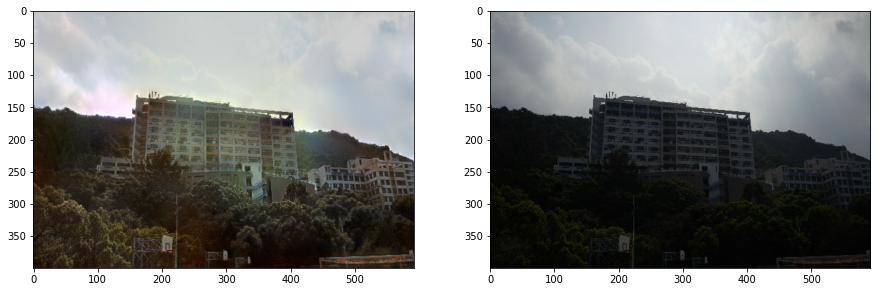

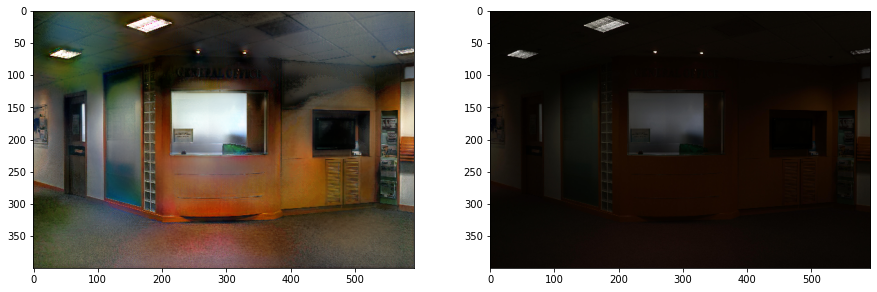

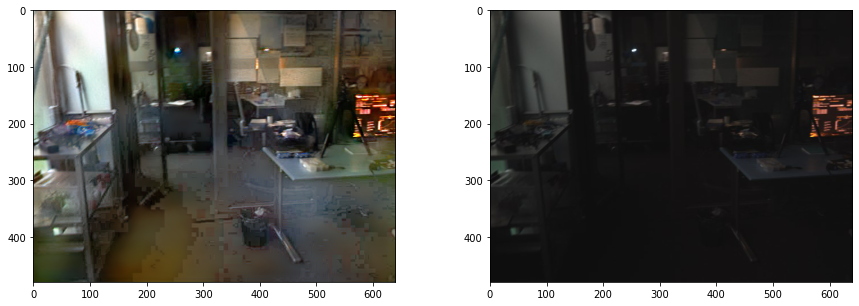

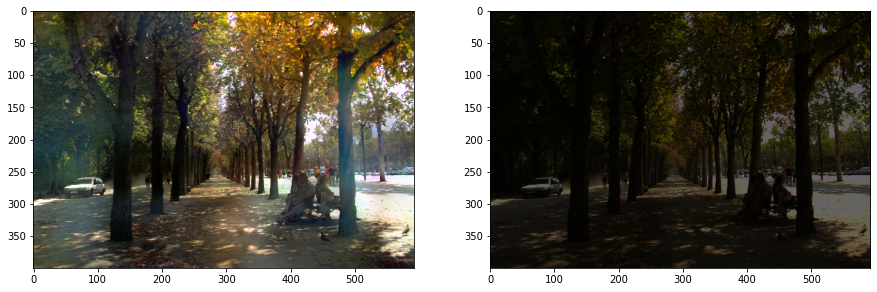

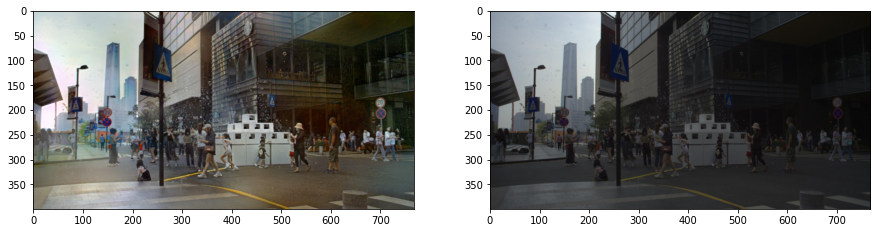

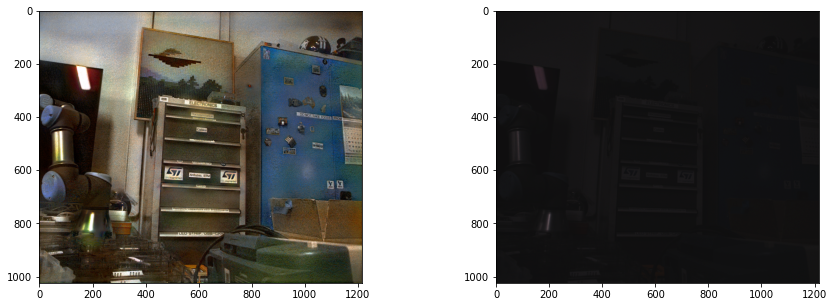

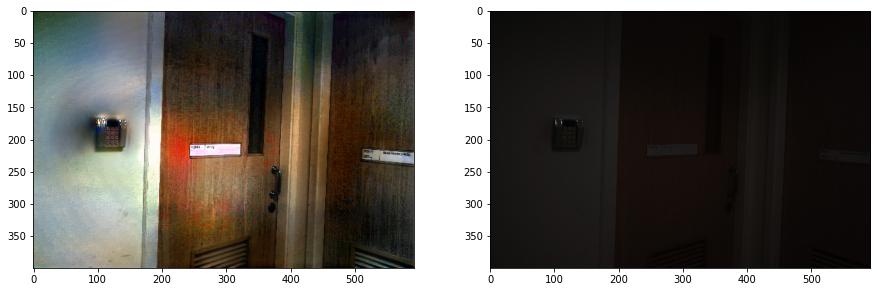

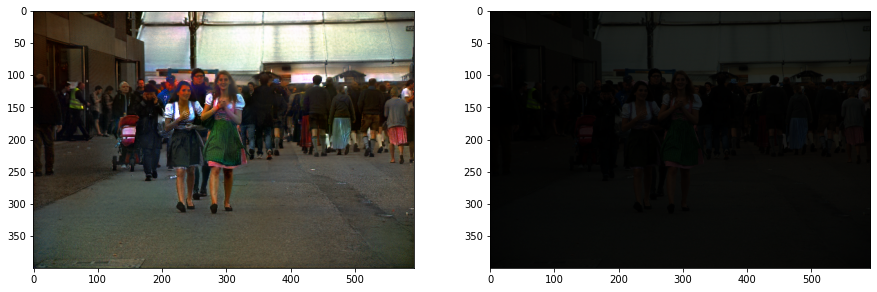

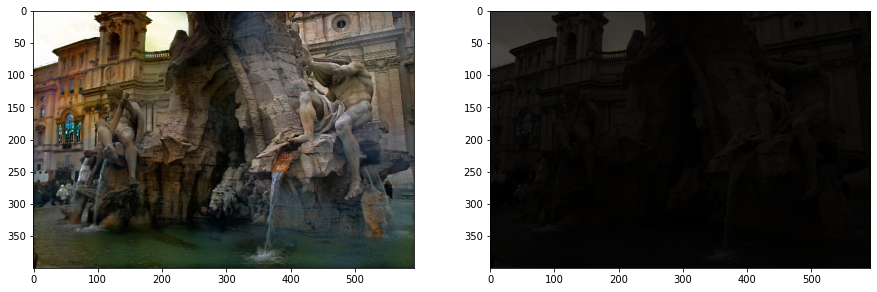

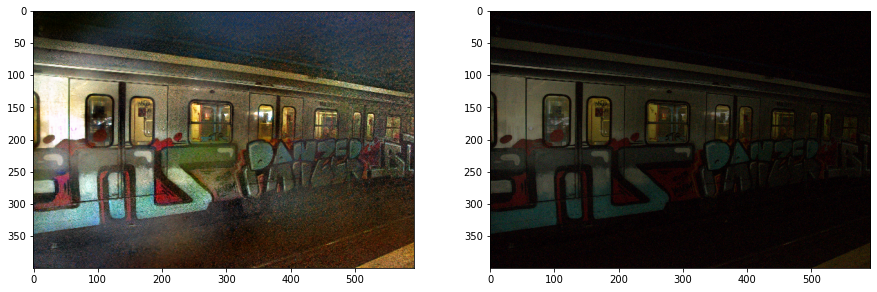

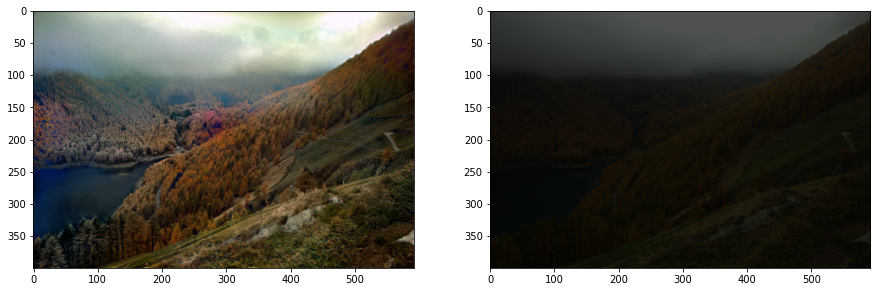

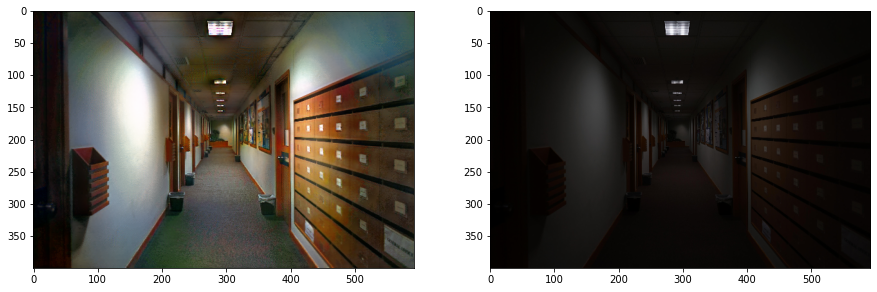

In [10]:
import cv2
save_root = '/home/student/Documents/alena/thesis/enlighte-gan-dataset/study/model-25-01-15-36'
for i in range(len(grays)):
    fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
    predicted = model_test._netG.forward(imgs_dark[i][None, :, :, :].cuda(), grays[i][None, :, :, :].cuda())
    img_type = ((predicted.detach().cpu()[0, :, :, :].permute(1, 2, 0) + 1 ) * 255 /2).numpy().astype(np.uint8)
    ax[0].imshow(img_type)
    ax[1].imshow((imgs_dark[i].permute(1, 2, 0) + 1) /2)
    plt.show()
    img_type = cv2.cvtColor(img_type, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_root + '/%i.png'%i, img_type)

In [37]:
save_root = '/home/student/Documents/alena/thesis/enlighte-gan-dataset/study/model-25-01-15-36'
save_root + '/%i.png'%i

'/home/student/Documents/alena/thesis/enlighte-gan-dataset/study/model-25-01-15-36/13.png'

0

In [10]:
img_type = cv2.cvtColor(img_type, cv2.COLOR_RGB2BGR)

error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 4 (CV_32S)


In [21]:
img_type.dtype

dtype('int64')

In [14]:
m = cv2.imread(path)

In [20]:
m.dtype

dtype('uint8')

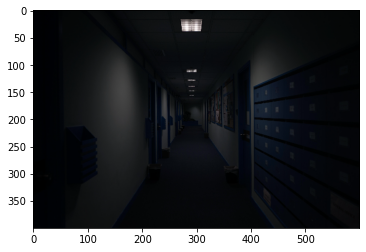

In [16]:
plt.imshow(m)

In [29]:
prediction = model_test._netD_global(imgs_dark[-1][None, :, :, :])

In [30]:
prediction.max()


tensor(0.2959, device='cuda:0', grad_fn=<MaxBackward1>)